# Overall description

In [ ]:
# This is an 3D example code based on SimPEG package.
# All cases are designed for on-land survey using 
# feequency domain CSEM method, with a line source.

# Author: Zhuo Liu, Colorado School of Mines
# Created in May, 2020

# Import packages

In [2]:
import math as m
import numpy as np
import SimPEG as spg
#from SimPEG import EM, Utils
from discretize import TreeMesh, TensorMesh
from SimPEG.utils  import ExtractCoreMesh
import SimPEG.electromagnetics.frequency_domain as FDEM
from discretize.utils import refine_tree_xyz
import pyvista as pv
from pymatsolver import Pardiso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook    # Activate interactivity of figures with backend
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 9]    # Set length and height of the canvas
#matplotlib.rcParams['figure.subplot.left'] = 0
#matplotlib.rcParams['figure.subplot.bottom'] = 0
#matplotlib.rcParams['figure.subplot.right'] = 1
#matplotlib.rcParams['figure.subplot.top'] = 1


# Define functions

In [3]:
# Self defined fucntions, for a succinct code and versatility

# Define function to construct anomalous bodies
def SinglebodyTensorMesh3D(core_x, core_y, core_z, core_hx, core_hy, core_hz, 
                           npadx, npady, npadz, pad_factor
                          ):
    '''
    Input: core_x/ core_y/ core_y: The length of core region in 3 directions in meter, int;
           core_hx/ core_hy/ core_hz: Cell widths in the core region of the mesh in meter, int;
           npadx/ npady/ npadz: Number of padding cells in each dimension;
           pad_factor: Padding factor
    
    Output: mesh: tensor mesh, with single densily-meshed region
    '''
    
    # Calculate the number of cells in core region
    n_core_x, n_core_y, n_core_z = int(core_x/core_hx), int(core_y/core_hy), int(core_z/core_hz)
    
    # Make meshed space
    mesh = TensorMesh([
        [(core_hx, npadx, -pad_factor), (core_hx, n_core_x), (core_hx, npadx, pad_factor)],
        [(core_hy, npady, -pad_factor), (core_hy, n_core_y), (core_hy, npady, pad_factor)],
        [(core_hz, npadz, -pad_factor), (core_hz, n_core_z), (core_hz, npadz, pad_factor)]
    ])
     
    return mesh


# Define function to construct anomalous bodies
def MultibodyTreeMesh3D(basemesh, x_bound, y_bound, z_bound, methods, tree_level):
    '''
    Input: basemesh: The basemesh need to be refined, SimPEG.Mesh;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           methods: Method to refine mesh.
           tree_level: 
    
    Output: mesh: Tree mesh with multiple anomalous region, mesh
    '''
    
    if len(x_bound) == len(y_bound) == len(z_bound):

        nbody = int(len(x_bound)/2)

        for n in range(nbody):
            # Construct vectors of all vertices for nth anomalous body
            xyz = spg.utils.ndgrid([np.r_[x_bound[2*n],x_bound[2*n+1]], 
                                    np.r_[y_bound[2*n],y_bound[2*n+1]], 
                                    np.r_[z_bound[2*n],z_bound[2*n+1]]])    # Extrate vertices for nth anomalous body

            # Discretize to finest cell size within rectangular box
            mesh = refine_tree_xyz(basemesh, xyz, 
                                   octree_levels=[tree_level[3*n], tree_level[3*n+1], tree_level[3*n+2]],
                                   #octree_levels_padding = [5, 5, 5]
                                   method=methods[n], 
                                   finalize=False
                                  )

        mesh.finalize()
    
    else:
        raise Exception('length of x_bound, y_bound, and z_bound should be same')
    
    return mesh


# Define function to fill the mesh with physical property values
def ModelConstruct3D(mesh, physivalue, x_bound, y_bound, z_bound):
    '''
    Input: mesh: The mesh created for modeling, SimPEG.Mesh;
           physivalue: Physical property values, 1D array;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
    
    Tip: 1. All inputs should be organized in an order from large-region to small-region;
         2. All bound values should be organized in an order from lower value to highre value.
    
    Output: model: the model, array
    '''
    
    nvalue = len(physivalue)
    
    model = np.ones(mesh.nC)    # Initialize model vector
    
    for i in range(nvalue):
        index = (
            (mesh.gridCC[:, 0]>=x_bound[2*i]) & (mesh.gridCC[:, 0]<=x_bound[2*i+1]) &
            (mesh.gridCC[:, 1]>=y_bound[2*i]) & (mesh.gridCC[:, 1]<=y_bound[2*i+1]) &
            (mesh.gridCC[:, 2]>=z_bound[2*i]) & (mesh.gridCC[:, 2]<=z_bound[2*i+1])
        )

        model[index] = physivalue[i]    #Set rock-background

    return model



# Define constants

In [4]:
# Set invariables

# Set constant
u = 4 * m.pi * 10**(-7)


# Set forward model

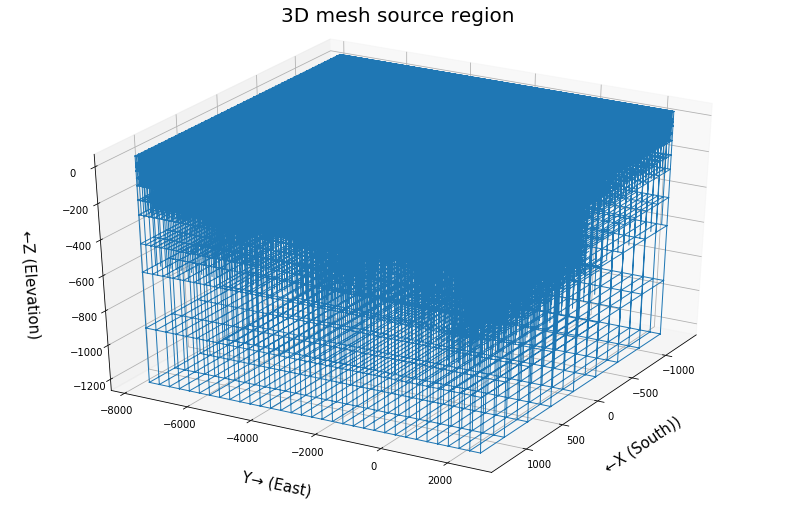

There are 209148 cells in the mesh


In [5]:
# Set model space and value


'''
# Here is an example of how to set a tensor mesh for a single-anomaly problem.
# Folloing code can be applied directly:

    # Set the length of core region in 3 directions
    core_x, core_y, core_z = 2100, 9000, 700    # Unit in meter    

    # cell widths in the core region of the mesh
    core_hx, core_hy, core_hz = 50, 50, 50    # Unit in meter

    # Number of padding cells in each dimension
    npadx, npady, npadz = 5, 5, 0

    # Padding factor
    pad_factor = 1.3

    mesh = SinglebodyTensorMesh3D(core_x, core_y, core_z, core_hx, core_hy, core_hz,
                                  npadx, npady, npadz, pad_factor)

    # Calculate the number of cells in core region

    # ↓↓↓ Have not figured out a better way to reconcile this line with the function above
    n_core_x, n_core_y, n_core_z = int(core_x/core_hx), int(core_y/core_hy), int(core_z/core_hz)

    # Shift the center of the tensor mesh
    mesh.x0 = np.r_[
        -(mesh.hx[0:npadx+int(0.5*n_core_x)].sum()),    # Set zeor in x-direction to the middle
        -(mesh.hy[0:npady+int(0.75*n_core_y)].sum()),    # Set zero in y-direction to the top
        -(mesh.hz[0:npadz+int(core_z/core_hz)-1].sum())    # Set zero in y-direction below one layer of core region
        ]

'''



#Here is an example of how to set a tree mesh for a multi-anomalies problem.
#Folloing code can be applied directly:

#Set the minimum cell size in each direction
base_dx, base_dy, base_dz = 20, 20, 20

# Set the number of the whole-model-space base cell in each dirction
nbc_x, nbc_y, nbc_z = 128, 512, 64

# Define the base mesh
hx = base_dx*np.ones(nbc_x)
hy = base_dy*np.ones(nbc_y)
hz = base_dz*np.ones(nbc_z)
basemesh = TreeMesh([hx, hy, hz],)

# Shift the center of model space
basemesh.x0 = np.r_[
    -(basemesh.hx.sum()*0.5),    # Shift 0-position in X direction
    -(basemesh.hy.sum()*0.75),    # Shift 0-position in Y direction
    -(basemesh.hz[0:nbc_z-2].sum())    # Set zero in z-direction below 15 layer of base mesh cells
    ]

# Set region for different mesh densities
# Normally these regions are slightly larger than the source region
x_bound=[-(basemesh.hx.sum()*0.5), (basemesh.hx.sum()*0.5),
         -600, -200,    # Anomalous area
         200, 600
         ] 
y_bound=[-(basemesh.hy.sum()*0.75), (basemesh.hy.sum()*0.25),
         800, 1200,
         800, 1200
        ] 
z_bound=[0, 0,
         -600, -200, 
         -600, -200
         ]

methods = ['surface', 'box', 'box']    # Method to refine mesh
tree_level = [1,1,1, 1,1,1, 1,1,1]    # Level of refinment

mesh = MultibodyTreeMesh3D(basemesh, x_bound, y_bound, z_bound, methods, tree_level)


# Plot the mesh and print the number of cells
meshfig = plt.figure(1)
meshplot = mesh.plotGrid()
plt.title('3D mesh source region\n', fontsize=20, loc='center')
meshplot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
meshplot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
meshplot.set_zlabel('\n\n\n ←Z (Elevation)', fontsize=15)
meshplot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
plt.show()
print(f"There are {mesh.nC} cells in the mesh")



<Figure size 1008x648 with 0 Axes>

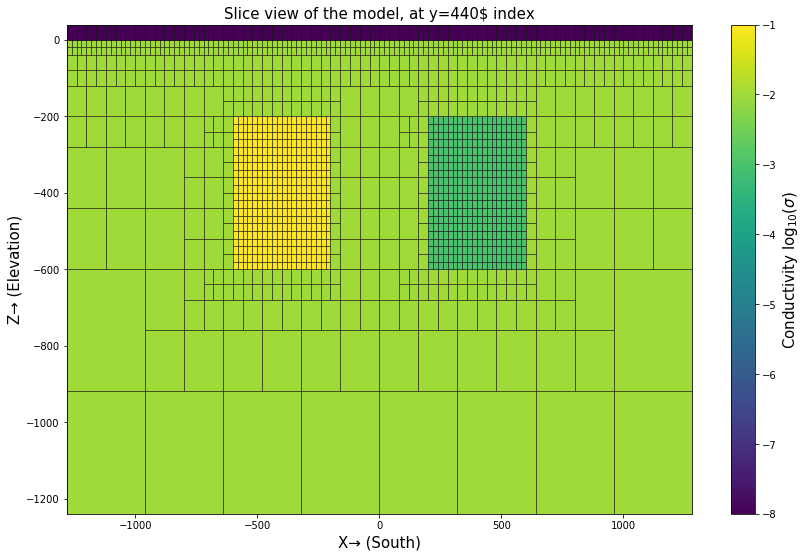

In [6]:
# Incorporate model value into the mesh
sigma_list = np.r_[1e-8, 0.01, 0.1, 0.001]    # Conductivity for air whole space, host-rock half space, and anomalous block

'''
# Section below is one example to set different region for physical values for tensor mesh.
# Folloing code can be applied directly:

    # Set the region for different mode lvalues
    x_bound_source=[mesh.gridFx.min(), mesh.gridFx.max(),
                    mesh.gridFx.min(), mesh.gridFx.max(),
                    -200, 200         
                    ] 
    y_bound_source=[mesh.gridFy.min(), mesh.gridFy.max(),
                    mesh.gridFy.min(), mesh.gridFy.max(),
                    -200, 200] 
    z_bound_source=[0, mesh.gridFz.max(),  
                    mesh.gridFz.min(), 0,
                    -600, -200
                    ]
'''

# Section below is one example to set different region for physical values for tree mesh.
# Folloing code can be applied directly

# Set the region for different mode lvalues
x_bound_source=[mesh.gridFx.min(), mesh.gridFx.max(),    # Air layer
                mesh.gridFx.min(), mesh.gridFx.max(),    # Host rock
                -600, -200,    # Conductive block 
                200, 600        
               ]
y_bound_source=[mesh.gridFy.min(), mesh.gridFy.max(),
                mesh.gridFy.min(), mesh.gridFy.max(),
                800, 1200,
                800, 1200
               ] 
z_bound_source=[0, mesh.gridFz.max(),
                mesh.gridFz.min(), 0,
                -600, -200,
                -600, -200
               ]

# Fill the meshed space with model values
sigma = ModelConstruct3D(mesh, sigma_list, x_bound_source, y_bound_source, z_bound_source)    # Fill model values to the mesh

# Plot the model, slice view
modelfig = plt.figure(2)
slicenorm = 'y'
slice_position = int(0.86*nbc_y)
modelplot = mesh.plotSlice(np.log10(sigma), normal=slicenorm, ind=slice_position, grid=True)
if slicenorm == 'y':
    plt.title(f'Slice view of the model, at y={slice_position}$ index', fontsize=15)
    plt.xlabel('X→ (South)', fontsize=15)
if slicenorm == 'x':
    plt.title(f'Slice view of the model, at x={slice_position}', fontsize=15)
    plt.xlabel('Y→ (East)', fontsize=15)
plt.ylabel('Z→ (Elevation)', fontsize=15)
bar2 = plt.colorbar(modelplot[0])
bar2.set_label(label='Conductivity $\log_{10}(\\sigma)$', fontsize=15)
plt.show()



# Set up survey

In [63]:
# Set up survey geometry

# Source parameters
# For line source, use solenoid to approximate. Place solenoid on the cell edge.
src_x_lim = [-500, 500]
src_loc_x = mesh.vectorNx[(mesh.vectorNx>=src_x_lim[0]) & (mesh.vectorNx<=src_x_lim[1])]    # Station location in x-direction
src_loc_y = np.r_[-6000]    # Station location in y-direction
src_loc_z = np.r_[0]    # Station location in z-direction
freq = np.r_[10]    # Source frequency in Hz

src_locs = spg.utils.ndgrid([src_loc_x, src_loc_y, src_loc_z])    # Sourrce coordinates
src_index = spg.utils.closestPoints(mesh, src_locs)[1:]    # [1:] is needed to drop the first point outside of the ssrc_x_lim
src_vec_x = np.zeros(mesh.nEx)
src_vec_y = np.zeros(mesh.nEy)
src_vec_z = np.zeros(mesh.nEz)
src_vec_x[src_index] = 100    # Source vector, 1 means that edge is a source
src_vec = np.hstack((src_vec_x, src_vec_y, src_vec_z))

# Receiver parameters
rx_loc_x = np.linspace(-1000,1000, 21)
rx_loc_y = np.linspace(0,2000, 21)
rx_loc_z = np.r_[0]
rx_locs = spg.utils.ndgrid(rx_loc_x, rx_loc_y, rx_loc_z)    # Receiver coordinates

# Set up the survey problem fir Electric field/data (E, with EB formulation)
rx_e_real = FDEM.receivers.PointElectricField(rx_locs, orientation="x",component='real')
rx_e_imag = FDEM.receivers.PointElectricField(rx_locs, orientation="x",component='imag')
rx_e = [rx_e_real, rx_e_imag]

# Set up the survey problem fir Magnetic field/data (H, with HJ fomulation)
rx_h_real = FDEM.receivers.PointMagneticField(rx_locs, orientation="x",component='real')
rx_h_imag = FDEM.receivers.PointMagneticField(rx_locs, orientation="x",component='imag')
rx_h = [rx_h_real, rx_h_imag]

# Setup source, approximate line souce by RawVec
srcList_e = [FDEM.sources.RawVec_e(rx_e, freq, src_vec)]    # Approximation of line source. Will change
srcList_h = [FDEM.sources.RawVec_m(rx_h, freq, src_vec)]    # magnetic term


# Calculate skin depth
skin_depth = 500./np.sqrt(sigma_list * freq)
print('Skin depths is between {:10.2} m and {:10.2} m' .format(skin_depth.min(), skin_depth.max()))



Skin depths is between      5e+02 m and    1.6e+06 m


In [64]:
# Set up survey and problem pair

# Define EM problem for E measurement
survey_e = FDEM.Survey(srcList_e)
simulation_e = FDEM.simulation.Simulation3DElectricField(mesh, sigmaMap = spg.maps.IdentityMap(mesh),
                                                         survey=survey_e,
                                                         Solver=Pardiso, verbose=True)

# Define EM problem for H measurement
survey_h = FDEM.Survey(srcList_h)
simulation_h = FDEM.simulation.Simulation3DMagneticField(mesh, sigmaMap = spg.maps.IdentityMap(mesh),
                                                         survey=survey_h,
                                                         Solver=Pardiso, verbose=True)

# Pair the physics and survey
simulation_e.pair(survey_e)
simulation_h.pair(survey_h)



<Figure size 1008x648 with 0 Axes>

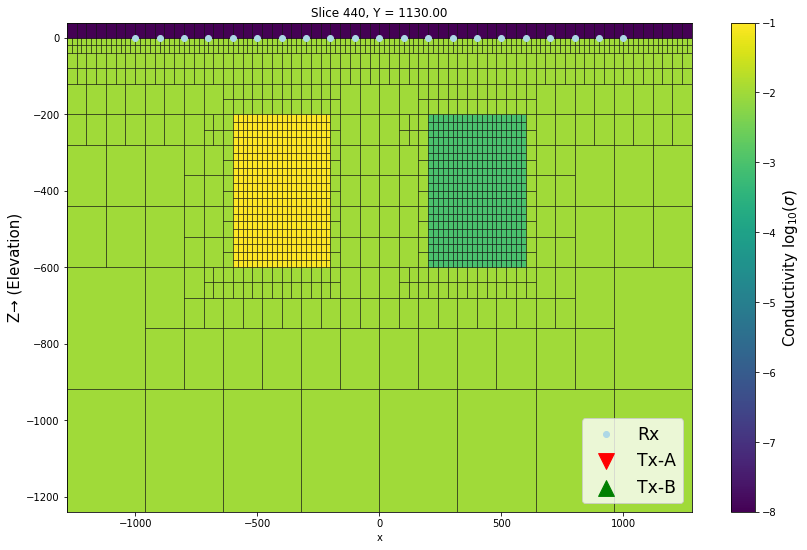

<Figure size 1008x648 with 0 Axes>

In [49]:
# Plot the problem and survey

# 2D slice plot of the survey and model
surveyfig = plt.figure(3)
slicenorm = 'y'
slice_position = int(0.86*nbc_y)
modelplot =  mesh.plotSlice(np.log10(sigma), normal=slicenorm, ind=slice_position, grid=True)
if slicenorm == 'x':
    #slice_position = ind=int(npady+int(0.8*n_core_y))
    #plt.title(f'Slice view of the model, at y={slice_position}', fontsize=15)
    plt.xlabel('X→ (South)', fontsize=15)
if slicenorm == 'x':
    #slice_position = ind=int(npady+int(0.8*n_core_y))
    #plt.title(f'Slice view of the model, at x={slice_position}', fontsize=15)
    plt.xlabel('Y→ (East)', fontsize=15)
plt.ylabel('Z→ (Elevation)', fontsize=15)
Rxlot = plt.scatter(rx_loc_x, rx_loc_z*np.ones_like(rx_loc_x), c='lightblue', label='Rx')
TxAlot = plt.scatter(src_loc_y, src_loc_z, marker='v', s=250, c='red', label='Tx-A')
TxBlot = plt.scatter(src_loc_y, src_loc_z, marker='^', s=250, c='green', label='Tx-B')
bar3 = plt.colorbar(modelplot[0])
bar3.set_label(label='Conductivity $\log_{10}(\\sigma)$', fontsize=15)
plt.legend(fontsize='xx-large', loc=4)
plt.show()


# 3D plot of the survey and model
surveyfig3D = plt.figure(4)

# Calculate field and data

In [65]:
# Calculate EM response

# Calculate fields
#e_field = simulation_e.fields(sigma)    # Electric field
#h_field = simulation_e.fields(sigma)    # Magnetic field

# Calculate electric data and magnetic data
e_data = simulation_e.dpred(sigma)    # Electric data
h_data = simulation_h.dpred(sigma)    # Magnetic data


# Plot results

In [41]:
# Plot fields
#Fieldfig = plt.figure(5)


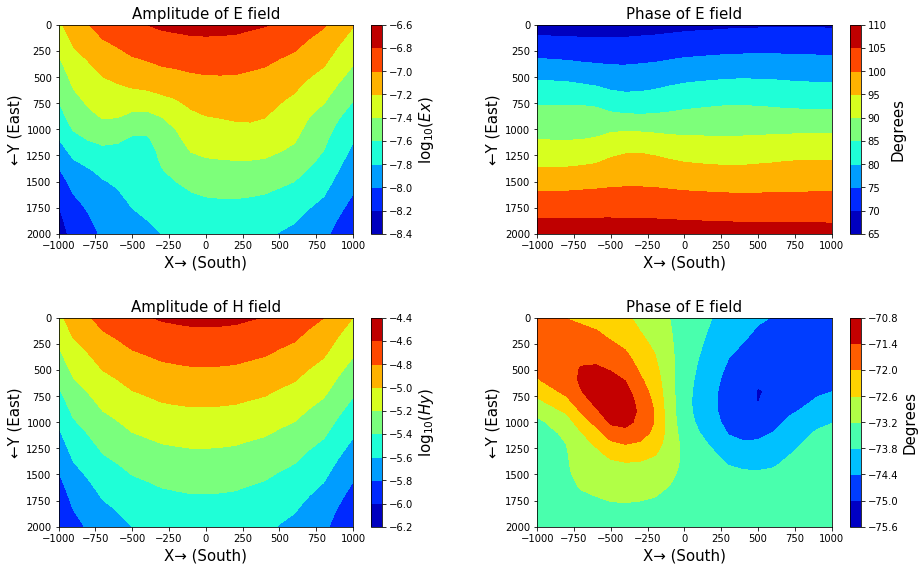

In [69]:
# Plot Data

# Separate real and imaginary parts
e_data_real = e_data[0:len(rx_locs)]    # Electric field data
e_data_imag = e_data[len(rx_locs):]
h_data_real = h_data[0:len(rx_locs)]    # Magnetic field data
h_data_imag = h_data[len(rx_locs):]

# Calculate data amplitude and phase
e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
e_phase = np.arctan2(e_data_imag, e_data_real)
h_amp = np.sqrt(h_data_real**2 + h_data_imag**2)    # Magnetic
h_phase = np.arctan2(h_data_imag, h_data_real)


Datafig = plt.figure(6)
if len(rx_loc_x) or len(rx_loc_y) != 1:
    # Reorganize results for plotting
    e_amp = np.reshape(e_amp, (len(rx_loc_x), len(rx_loc_y)))
    e_phase = np.reshape(e_phase, (len(rx_loc_x), len(rx_loc_y)))
    h_amp = np.reshape(h_amp, (len(rx_loc_x), len(rx_loc_y)))
    h_phase = np.reshape(h_phase, (len(rx_loc_x), len(rx_loc_y)))

    plt.subplots_adjust(top=0.9, bottom=0.125, left=0.11, right=0.95,
                        wspace=0.3, hspace=0.4)
    # Plot results 
    eplot1 = plt.subplot(221)
    eplot1.set_title('Amplitude of E field', fontsize=15)
    e_amp_plot = eplot1.contourf(rx_loc_x, rx_loc_y, np.log10(e_amp), cmap='jet')
    eplot1.set_ylabel('←Y (East)', fontsize='15')
    eplot1.set_xlabel('X→ (South)', fontsize='15')
    plt.gca().invert_yaxis()
    bar_5221 = plt.colorbar(e_amp_plot)
    bar_5221.set_label(label='$\log_{10}(Ex)$', fontsize=15)
    
    eplot2 = plt.subplot(222)
    eplot2.set_title('Phase of E field', fontsize=15)
    e_phase_plot = eplot2.contourf(rx_loc_x, np.flip(rx_loc_y), np.degrees(e_phase), cmap='jet')
    eplot2.set_ylabel('←Y (East)', fontsize='15')
    eplot2.set_xlabel('X→ (South)', fontsize='15')  
    plt.gca().invert_yaxis()
    bar_5222 = plt.colorbar(e_phase_plot)
    bar_5222.set_label(label='Degrees', fontsize=15)
    
    hplot1 = plt.subplot(223)
    hplot1.set_title('Amplitude of H field', fontsize=15)
    h_amp_plot = hplot1.contourf(rx_loc_x, rx_loc_y, np.log10(h_amp), cmap='jet')
    hplot1.set_ylabel('←Y (East)', fontsize='15')
    hplot1.set_xlabel('X→ (South)', fontsize='15')
    plt.gca().invert_yaxis()
    bar_5223 = plt.colorbar(h_amp_plot)
    bar_5223.set_label(label='$\log_{10}(Hy)$', fontsize=15)
    
    hplot2 = plt.subplot(224)
    hplot2.set_title('Phase of E field', fontsize=15)
    h_phase_plot = hplot2.contourf(rx_loc_x, np.flip(rx_loc_y), np.degrees(h_phase), cmap='jet')
    hplot2.set_ylabel('←Y (East)', fontsize='15')
    hplot2.set_xlabel('X→ (South)', fontsize='15')  
    plt.gca().invert_yaxis()
    bar_5224 = plt.colorbar(h_phase_plot)
    bar_5224.set_label(label='Degrees', fontsize=15)
    
    plt.show()   
    
    
else:
    e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
    e_phase = np.arctan2(e_data_imag, e_data_real)

    eplot = plt.subplot(111)
    eplot.semilogy(rx_loc_x, (e_amp), label='Ez Amplitude', linewidth=5)
    #eplot.plot(rx_loc_x, np.degrees(e_phase), marker='.', label='Phase (degree)')
    eplot.set_ylabel('Ez Ampliture (V/m)', fontsize='15')
    eplot.set_xlabel('Rx location', fontsize='15')
    plt.legend(fontsize='xx-large')

    #bplot = plt.subplot(122)
    #bplot.plot(rx_loc_x, np.log10(b_amp), label='Amplitude', linewidth=5)
    #bplot.plot(rx_loc_x, np.degrees(b_phase), marker='.', label='Phase (degree)')

    plt.legend(fontsize='xx-large')
    plt.show()
    
 
    

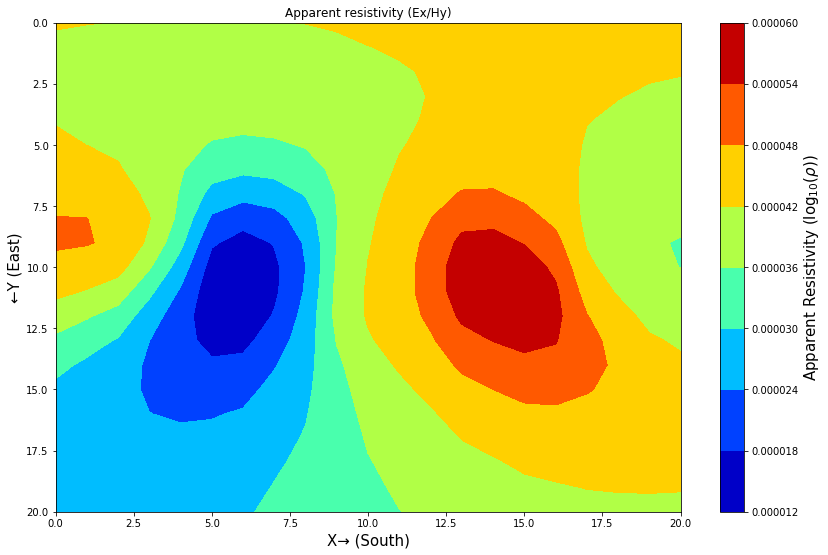

In [75]:
# Plot apparent resistivity

rhoapp_fig = plt.figure(6)
rhoapp_plot = plt.subplot(111)
rhoapp_plot.set_title('Apparent resistivity (Ex/Hy)')
rhoapp = rhoapp_plot.contourf((np.abs(e_amp/h_amp))**2, cmap='jet')
rhoapp_plot.set_ylabel('←Y (East)', fontsize='15')
rhoapp_plot.set_xlabel('X→ (South)', fontsize='15')  
plt.gca().invert_yaxis()
bar_6 = plt.colorbar(rhoapp)
bar_6.set_label(label='Apparent Resistivity ($\log_{10}(\\rho)$)', fontsize=15)
plt.show()